In [8]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from read_file import *
from indicators import *
import os

## Première procédure de résolution
### Phase I

In [9]:
## Loading data
n = 200
p = 6
filename = f"./data/2KP200-TA-0.dat"

w=np.zeros(n,dtype=int) # poids des objets
v=np.zeros((n,p),dtype=int) # utilités des objets
W = readFile(filename,w,v)

# ====== On prend un sous-ensemble du problème ====
n = 50
p = 3
w = w[:n]
v = v[:n,:p]
W = w.sum()//2
print(w.shape, v.shape, W)

(50,) (50, 3) 13299


In [10]:
## Phase I: generate non-dominated solution with PLS
params = (n,p,v,w,W)
m = 20
verbose = True
NBMAX = 20

YND = PLS(m,params,NBMAX,verbose= False)
points = list(map(lambda x: x[1], YND))
points = np.array(points)
print(f'nombre de points non-dominés trouvés: {len(points)}')

nombre de points non-dominés trouvés: 268


In [4]:
# On sauvegarde les points dans l'espace des critères
file_output = './sol/I2dim.sol'
if not os.path.isfile(file_output):
    np.savetxt(file_output, points)
points = np.loadtxt(file_output)
points = points.astype(int)
YND = [(None,p) for p in points]
points.shape

(272, 3)

### Phase II: 

In [18]:
# On génère les paramètres du décideur
mode = 'Choquet'
p = points.shape[1]
DM = DecisionMaker(p, mode)

# Solution optimale pour le décideur
scores = [DM.value(y) for y in YND]
opt = points[np.argmax(scores)]
opt

array([20260, 19926, 18312])

In [25]:
DM_opt = get_opt_choquet(params, DM.params)
print(DM_opt)
sol = int(DM_opt[0],2)

y = np.array([v[i] for i in range(n) if sol & 1<<i])
print(y.sum(0))

8
8 8
('11101111011111101011111110101001101010010110111001', 19181.17981219009)
[20260 19926 18312]


In [26]:
eps = 1e-4
model = Model(dim=p, mode=mode)

o1, o2, regret = model.CSS(YND)
minmax_regrets = [regret]

print(f'Start | {regret =: .2f}')
print(o1[1], o2[1])
it = 1

# ### CORRIGER LE SORT
#
while regret > eps:
    if DM.ask(o1, o2): model.update(o1,o2)
    else: model.update(o2,o1)
    o1, o2, regret = model.CSS(YND)
    minmax_regrets.append(regret)
    print(f'{it = } | {regret =: .2f} | {o1[1]} {o2[1]}')
    it += 1

Init Choquet Model
Start | regret = 0.31
[20507 19325 17899] [18773 20937 16314]
it = 1 | regret = 0.28 | [20688 18746 18038] [20165 20241 16361]
it = 2 | regret = 0.26 | [20663 18524 18138] [21989 17434 14928]
it = 3 | regret = 0.16 | [19736 18878 18717] [20929 19710 17630]
it = 4 | regret = 0.09 | [19326 18843 19077] [18411 20722 17940]
it = 5 | regret = 0.07 | [19326 18843 19077] [18290 17341 19459]
it = 6 | regret = 0.06 | [19552 18934 18893] [19131 17957 19234]
it = 7 | regret = 0.06 | [19552 18934 18893] [20260 19926 18312]
it = 8 | regret = 0.05 | [20260 19926 18312] [20544 18165 18500]
it = 9 | regret = 0.04 | [20260 19926 18312] [17771 19908 18626]
it = 10 | regret = 0.04 | [20260 19926 18312] [18804 20057 18535]
it = 11 | regret = 0.02 | [20260 19926 18312] [19562 18331 19149]
it = 12 | regret = 0.02 | [20260 19926 18312] [19326 18843 19077]
it = 13 | regret = 0.01 | [20260 19926 18312] [20479 18580 18314]
it = 14 | regret = 0.01 | [20260 19926 18312] [19120 19294 18777]
it =

Text(0, 0.5, 'minimax regret')

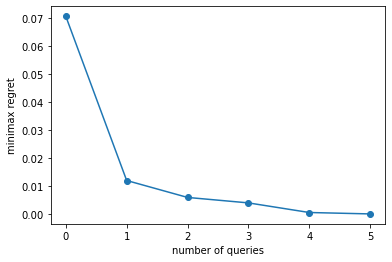

In [16]:
plt.plot(minmax_regrets, 'o-')
plt.xlabel('number of queries')
plt.ylabel('minimax regret')